## Insurance Support Ticket Classifier

In [74]:
import os
import json
import pickle
import random
import textwrap
import numpy as np
import pandas as pd
import concurrent.futures
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from dotenv import load_dotenv

from openai import OpenAI

load_dotenv()

True

In [70]:
MODEL = "gpt-5-nano"
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

## Classification with LLMs
Large Language Models (LLMs) have revolutionized the field of classification, particularly in areas where traditional machine learning systems have faced challenges. LLMs have demonstrated remarkable success in handling classification problems characterized by complex business rules and scenarios with low-quality or limited training data. Additionally, LLMs have the capability of providing natural language explanations and justifications for their actions, enhancing the interpretability and transparency of the classification process. By leveraging the power of LLMs, we can build classification systems that go beyond the capabilities of traditional machine learning approaches and excel in scenarios where data is scarce or business requirements are intricate.

### Problem Definition: Insurance Support Ticket Classifier

In the insurance industry, customer support plays a crucial role in ensuring client satisfaction and retention. Insurance companies receive a high volume of support tickets daily, covering a wide range of topics such as billing, policy administration, claims assistance, and more. Manually categorizing these tickets can be time-consuming and inefficient, leading to longer response times and potentially impacting customer experience.

### Loading and Preparing the Data 

In [5]:
train_df = pd.read_csv("./data/train.tsv", sep="\t")
test_df = pd.read_csv("./data/test.tsv", sep="\t")

train_df.head(2)

,text,label
0,I just got my auto policy renewal bill and the...,Billing Inquiries
1,The premium for my car insurance renewal is hi...,Billing Inquiries


In [7]:
# Understand the labels in the dataset
labels = list(set(train_df["label"].unique()))

labels

['Claims Disputes',
 'Quotes and Proposals',
 'Billing Disputes',
 'Coverage Explanations',
 'Policy Administration',
 'Account Management',
 'General Inquiries',
 'Policy Comparisons',
 'Claims Assistance',
 'Billing Inquiries']

In [8]:
train_df.shape, test_df.shape

((68, 2), (68, 2))

In [16]:
X_test = test_df['text'].to_list()
y_test = test_df['label'].to_list()

## Evaluation Framework

Before we build our classifiers, let's set up an evaluation framework to measure their performance. We'll create two key functions:

1. `evaluate(X, y, classifier, batch_size)`: Runs your classifier on all test examples using concurrent execution for speed, then calculates accuracy metrics and generates a confusion matrix. The batch_size parameter controls how many concurrent API requests to make.

2. `plot_confusion_matrix(cm, labels)`: Visualizes the confusion matrix to show which categories are being confused with each other, helping identify where the classifier struggles.

This framework allows us to empirically compare different classification approaches and understand not just overall accuracy, but which specific categories are challenging.

In [11]:
MAXIMUM_CONCURRENT_REQUESTS = 1

def plot_confusion_matrix(cm, labels):
    # Visualize the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, cmap="Blues")

    # Add colorbar
    ax.figure.colorbar(im, ax=ax)

    # Set tick labels and positions
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)

    # Add labels to each cell
    thresh = cm.max() / 2.0
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(
                j,
                i,
                cm[i, j],
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    # Set labels and title
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

def evaluate(X, y, classifier, batch_size=MAXIMUM_CONCURRENT_REQUESTS):
    # Initialize lists to store the predicted and true labels
    y_true = []
    y_pred = []

    # Store results with their original index to maintain order
    results = [None] * len(X)

    # Create a ThreadPoolExecutor with limited workers
    with concurrent.futures.ThreadPoolExecutor(max_workers=batch_size) as executor:
        # Submit tasks one at a time, but executor will only run batch_size concurrently
        future_to_index = {executor.submit(classifier, x): i for i, x in enumerate(X)}

        # Process results as they complete
        for future in concurrent.futures.as_completed(future_to_index):
            index = future_to_index[future]
            predicted_label = future.result()
            results[index] = predicted_label

    # Extract predictions and true labels in order
    y_pred = results
    y_true = y

    # Normalize y_true and y_pred
    y_true = [label.strip() for label in y_true]
    y_pred = [label.strip() for label in y_pred]

    # Calculate the classification metrics
    report = classification_report(y_true, y_pred, labels=labels, zero_division=1)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(report)
    plot_confusion_matrix(cm, labels)

## Baseline: Random Classifier

To establish a performance baseline and verify our evaluation framework works correctly, let's start with a random classifier that picks a category at random for each ticket.

This gives us a lower bound on performance: any real classification approach should significantly outperform random guessing (which should achieve roughly 10% accuracy with 10 categories). This baseline helps us quantify how much value our context engineering actually adds. 

In [13]:
def random_classifier(text):
    return random.choice(labels)

Evaluating the random classification method on the test set...
                       precision    recall  f1-score   support

      Claims Disputes       0.00      0.00      0.00         9
 Quotes and Proposals       0.00      0.00      0.00         5
     Billing Disputes       0.11      0.11      0.11         9
Coverage Explanations       0.12      0.11      0.12         9
Policy Administration       0.00      0.00      0.00         6
   Account Management       0.20      0.33      0.25         6
    General Inquiries       0.00      0.00      0.00         7
   Policy Comparisons       0.00      0.00      0.00         5
    Claims Assistance       0.17      0.17      0.17         6
    Billing Inquiries       0.00      0.00      0.00         6

             accuracy                           0.07        68
            macro avg       0.06      0.07      0.06        68
         weighted avg       0.06      0.07      0.07        68



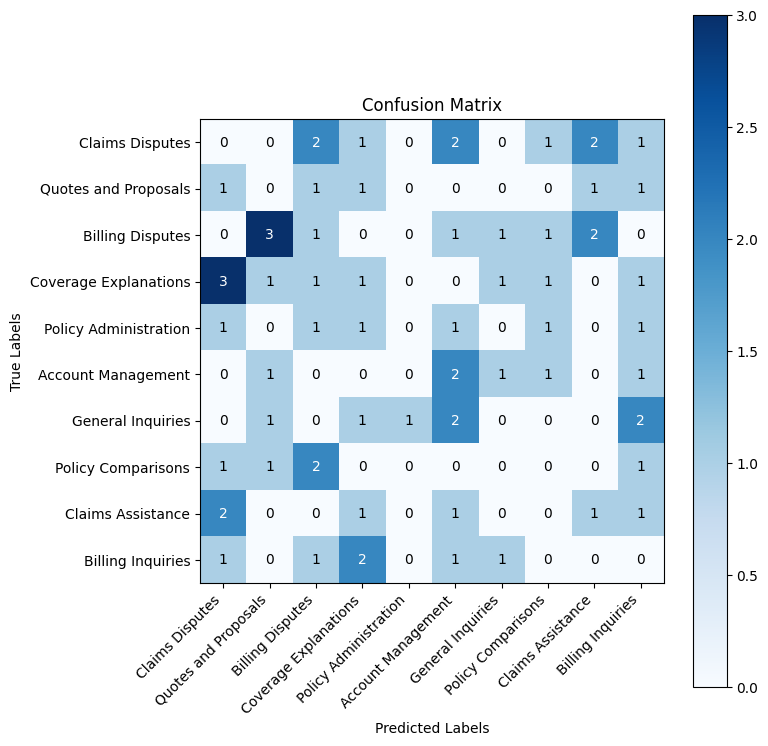

In [17]:
print("Evaluating the random classification method on the test set...")
evaluate(X_test, y_test, random_classifier)

As expected from random guessing, the confusion matrix shows predictions scattered across all categories with no meaningful pattern. The diagonal (correct predictions) shows only 1-2 correct classifications per category, while errors are distributed randomly.

This confirms our baseline of approximately 7% accuracy—purely chance performance with 10 categories. Any structured classification approach should show a much stronger diagonal pattern, indicating the model is actually learning the category distinctions rather than guessing.

## Simple Classification Test

Now lets construct a simple classifier using OpenAI.

First we will encode the categories in XML format. This will make it easier for model to interpret the information.

In [19]:
categories = textwrap.dedent("""<category>
    <label>Billing Inquiries</label>
    <content> Questions about invoices, charges, fees, and premiums Requests for clarification on billing statements Inquiries about payment methods and due dates
    </content>
</category>
<category>
    <label>Policy Administration</label>
    <content> Requests for policy changes, updates, or cancellations Questions about policy renewals and reinstatements Inquiries about adding or removing coverage options
    </content>
</category>
<category>
    <label>Claims Assistance</label>
    <content> Questions about the claims process and filing procedures Requests for help with submitting claim documentation Inquiries about claim status and payout timelines
    </content>
</category>
<category>
    <label>Coverage Explanations</label>
    <content> Questions about what is covered under specific policy types Requests for clarification on coverage limits and exclusions Inquiries about deductibles and out-of-pocket expenses
    </content>
</category>
<category>
    <label>Quotes and Proposals</label>
    <content> Requests for new policy quotes and price comparisons Questions about available discounts and bundling options Inquiries about switching from another insurer
    </content>
</category>
<category>
    <label>Account Management</label>
    <content> Requests for login credentials or password resets Questions about online account features and functionality Inquiries about updating contact or personal information
    </content>
</category>
<category>
    <label>Billing Disputes</label>
    <content> Complaints about unexpected or incorrect charges Requests for refunds or premium adjustments Inquiries about late fees or collection notices
    </content>
</category>
<category>
    <label>Claims Disputes</label>
    <content> Complaints about denied or underpaid claims Requests for reconsideration of claim decisions Inquiries about appealing a claim outcome
    </content>
</category>
<category>
    <label>Policy Comparisons</label>
    <content> Questions about the differences between policy options Requests for help deciding between coverage levels Inquiries about how policies compare to competitors' offerings
    </content>
</category>
<category>
    <label>General Inquiries</label>
    <content> Questions about company contact information or hours of operation Requests for general information about products or services Inquiries that don't fit neatly into other categories
    </content>
</category>""")

### Building the Simple Classifier

Now let's build our first real classifier using openAI. The `simple_classify` function demonstrates three key prompt engineering techniques:

1. **Structured prompt template**: We provide the category definitions and the support ticket in a clear XML format, making it easy for model to parse the information.

2. **Controlled output with prefilling**: By starting the assistant's response with `<category>` and setting `stop_sequences=["</category>"]`, we force model to output just the category label—no explanation or extra text. This makes response parsing reliable and deterministic.

3. **Deterministic classification**: Setting `temperature=0.0` ensures consistent predictions for the same input, which is critical for classification tasks.

In [71]:
def simple_classify(X):
    prompt = textwrap.dedent("""
        You will classify a customer support ticket into one of the following categories:
        <categories>
            {{categories}}
        </categories>

        Here is the customer support ticket:
        <ticket>
            {{ticket}}
        </ticket>

        Respond with just the label of the category.
    """).replace("{{categories}}", categories).replace("{{ticket}}", X)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[
                {
                    "role": "user", 
                    "content": prompt
                },
            ]
    )

    return response.choices[0].message.content

In [72]:
simple_classify(X_test[0])

'Billing Inquiries'

Evaluating the simple classification method on the test set...
                       precision    recall  f1-score   support

      Claims Disputes       1.00      1.00      1.00         9
 Quotes and Proposals       1.00      0.60      0.75         5
     Billing Disputes       0.71      0.56      0.62         9
Coverage Explanations       0.45      1.00      0.62         9
Policy Administration       0.83      0.83      0.83         6
   Account Management       1.00      0.83      0.91         6
    General Inquiries       1.00      0.00      0.00         7
   Policy Comparisons       0.71      1.00      0.83         5
    Claims Assistance       1.00      0.50      0.67         6
    Billing Inquiries       0.50      0.67      0.57         6

             accuracy                           0.71        68
            macro avg       0.82      0.70      0.68        68
         weighted avg       0.81      0.71      0.68        68



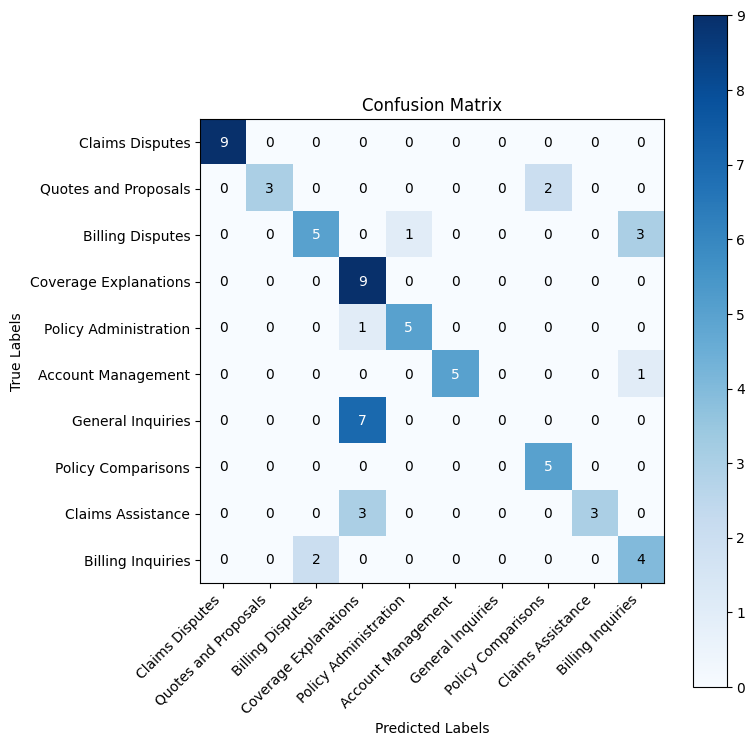

In [73]:
print("Evaluating the simple classification method on the test set...")
evaluate(X_test, y_test, simple_classify)

Much better! The confusion matrix shows a strong diagonal pattern with most categories achieving high accuracy.

This `~70%` overall accuracy significantly outperforms random guessing, but the confusion between similar categories suggests gpt-model needs more context to make finer distinctions.

To address these confusion patterns, we'll add **retrieval-augmented generation (RAG)** by providing the model with relevant examples from our training data. Here's how it works:

1. **Embed training examples**: Convert all 68 training tickets into vector embeddings using VoyageAI's embedding model
2. **Semantic search**: For each new ticket, find the 5 most similar training examples based on cosine similarity
3. **Augment the prompt**: Include these similar examples in the classification prompt to guide model

This approach is particularly effective for classification because:
- Similar past examples help model distinguish between semantically close categories
- Few-shot learning improves accuracy without fine-tuning
- The retrieval is dynamic—each query gets the most relevant examples

We'll build a simple VectorDB class to handle embedding storage and similarity search using VoyageAI's embedding models.

In [94]:
data = dict()
data["train"] = train_df.apply(lambda x: {"text": x["text"], "label": x["label"]}, axis=1).tolist()
data["test"] = test_df.apply(lambda x: {"text": x["text"], "label": x["label"]}, axis=1).tolist()

In [128]:
class VectorDB:
    def __init__(self, api_key=None):
        if api_key is None:
            api_key = os.getenv("OPENAI_API_KEY")

        self.client = OpenAI(api_key=api_key)

        self.embeddings = []
        self.metadata = []
        self.query_cache = {}
        self.db_path = "./data/vector_db.pkl"

        self.model = "text-embedding-3-small"  # OpenAI embedding model

    def load_data(self, data):

        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return

        if os.path.exists(self.db_path):
            print("Loading vector database from disk.")
            self.load_db()
            return

        texts = [item["text"] for item in data]

        batch_size = 128
        all_embeddings = []

        for i in range(0, len(texts), batch_size):
            batch = texts[i : i + batch_size]

            response = self.client.embeddings.create(
                model=self.model,
                input=batch
            )

            batch_embeddings = [item.embedding for item in response.data]
            all_embeddings.extend(batch_embeddings)

        self.embeddings = all_embeddings
        self.metadata = [item for item in data]

        self.save_db()
        print("Vector database loaded and saved.")

    def search(self, query, k=5, similarity_threshold=0.75):

        if query in self.query_cache:
            query_embedding = self.query_cache[query]
        else:
            response = self.client.embeddings.create(
                model=self.model,
                input=query
            )
            query_embedding = response.data[0].embedding
            self.query_cache[query] = query_embedding

        if len(self.embeddings) == 0:
            raise ValueError("No data loaded in the vector database.")

        similarities = np.dot(self.embeddings, query_embedding)

        top_indices = np.argsort(similarities)[::-1]
        top_examples = []

        for idx in top_indices:
            if similarities[idx] >= similarity_threshold:
                example = {
                    "metadata": self.metadata[idx],
                    "similarity": float(similarities[idx]),
                }
                top_examples.append(example)

                if len(top_examples) >= k:
                    break

        self.save_db()
        return top_examples

    def save_db(self):

        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }

        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)

    def load_db(self):

        if not os.path.exists(self.db_path):
            raise ValueError(
                "Vector database file not found. Use load_data to create a new database."
            )

        with open(self.db_path, "rb") as file:
            data = pickle.load(file)

        self.embeddings = data["embeddings"]
        self.metadata = data["metadata"]
        self.query_cache = json.loads(data["query_cache"])

In [131]:
vectordb = VectorDB()
vectordb.load_data(data["train"])

Vector database loaded and saved.


In [132]:
vectordb.search("I just got my auto policy renewal bill and the cost seems to be more than what I usually pay. Could you explain the reason for the increase?")

[{'metadata': {'text': 'I just got my auto policy renewal bill and the cost seems to be more than what I usually pay. Could you explain the reason for the increase?',
   'label': 'Billing Inquiries'},
  'similarity': 0.9999995100515425},
 {'metadata': {'text': 'I need some help understanding why my auto insurance bill for the upcoming term is more expensive than it has been in the past. Could you provide an explanation?',
   'label': 'Billing Inquiries'},
  'similarity': 0.8069457400971937},
 {'metadata': {'text': 'The premium for my car insurance renewal is higher than I expected. Can you clarify why there was a price increase compared to my previous policy?',
   'label': 'Billing Inquiries'},
  'similarity': 0.7977830739994094}]

## RAG-Enhanced Classifier

Now let's rebuild our classifier with retrieval-augmented generation. The `rag_classify` function enhances the simple classifier by:

1. **Retrieving similar examples**: For each ticket, we search the vector database for the 5 most semantically similar training examples
2. **Formatting as few-shot examples**: We structure these examples in XML format with `<query>` and `<label>` tags, showing model how similar tickets were classified
3. **Augmenting the prompt**: We inject these examples into the prompt before asking model to classify the new ticket

This few-shot learning approach helps model make better distinctions between similar categories by showing concrete examples of how tickets with similar language should be categorized. For instance, if the test ticket mentions **"unexpected charges"**, retrieving examples of past **"Billing Disputes"** vs **"Billing Inquiries"** helps model understand the subtle difference.

Let's see how much this improves our accuracy on the confused categories from the previous run

In [133]:
def rag_classify(X):
    rag = vectordb.search(X, 5)
    rag_string = ""
    for example in rag:
        rag_string += textwrap.dedent(f"""
        <example>
            <query>
                "{example["metadata"]["text"]}"
            </query>
            <label>
                {example["metadata"]["label"]}
            </label>
        </example>
        """)
    
    prompt = (
        textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Use the following examples to help you classify the query:
    <examples>
        {{examples}}
    </examples>

    Respond with just the label of the category.
    """)
        .replace("{{categories}}", categories)
        .replace("{{ticket}}", X)
        .replace("{{examples}}", rag_string)
    )
    
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
                {
                    "role": "user", 
                    "content": prompt
                },
            ]
    )

    return response.choices[0].message.content

In [134]:
rag_classify(X_test[0])

'Billing Inquiries'

Evaluating the RAG method on the test set...
                       precision    recall  f1-score   support

      Claims Disputes       1.00      1.00      1.00         9
 Quotes and Proposals       1.00      1.00      1.00         5
     Billing Disputes       0.90      1.00      0.95         9
Coverage Explanations       1.00      1.00      1.00         9
Policy Administration       1.00      1.00      1.00         6
   Account Management       1.00      1.00      1.00         6
    General Inquiries       1.00      1.00      1.00         7
   Policy Comparisons       1.00      1.00      1.00         5
    Claims Assistance       1.00      1.00      1.00         6
    Billing Inquiries       1.00      0.83      0.91         6

             accuracy                           0.99        68
            macro avg       0.99      0.98      0.99        68
         weighted avg       0.99      0.99      0.99        68



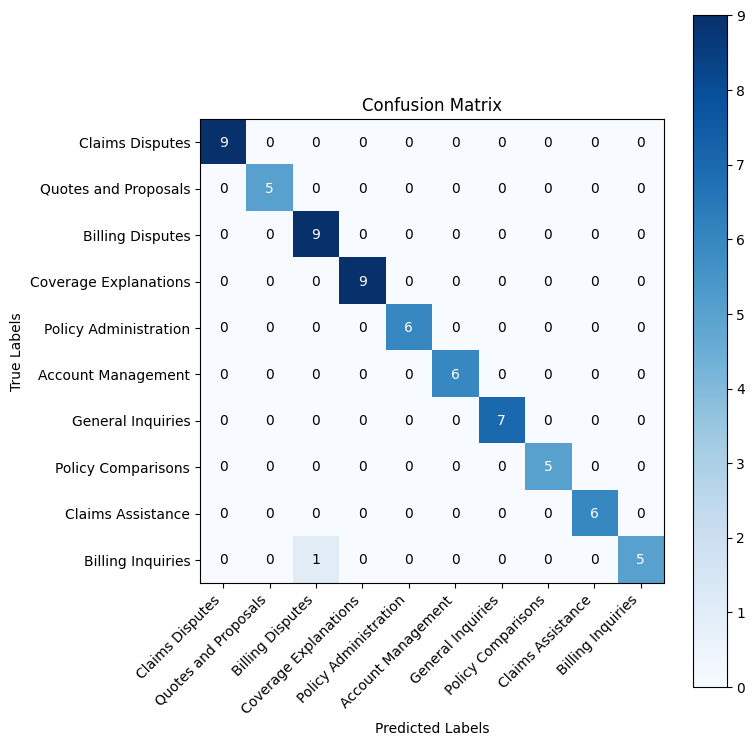

In [135]:
print("Evaluating the RAG method on the test set...")
evaluate(X_test, y_test, rag_classify)

### RAG Results Analysis
RAG boosted our accuracy from ~70% to 99%. The confusion matrix shows a much stronger diagonal, with almost all categories now achieving perfect accuracy except one. This strategy pushed our accuracy to 99%, resolving most of the edge cases that challenged the previous approaches.

The model used in this experiment `gpt-5-nano` is a **Chain-of-Thought** reasoning model, which greatly helped in classification. This capability of LLMs helps model in catching subtle distinctions that might be missed with direct classification. For example, distinguishing *"I have a question about my bill"* **(Billing Inquiry)** from *"This charge seems wrong"* **(Billing Dispute)** requires understanding intent and tone—something that benefits from step-by-step analysis.

#### Progressive improvement summary:

- Random baseline: ~10% accuracy
- Simple classifier: ~71% accuracy
- RAG classifier: 99% accuracy

By explicitly reasoning through each classification decision, LLM better distinguishes between ambiguous cases.